<a href="https://colab.research.google.com/github/Dp20032/Neuromatch_BrainCancer/blob/Dhiren/Copy_of_VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

import os
from google.colab import files
from PIL import Image
import subprocess

import random
random.seed(2023)

In [3]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 89% 132M/149M [00:01<00:00, 124MB/s]
100% 149M/149M [00:01<00:00, 90.4MB/s]


In [4]:
# @title Download and processing Zenodo data - unneeded, data represented in original dataset
#!wget https://zenodo.org/record/7047164/files/adnoma.zip
#!wget https://zenodo.org/record/7047164/files/Gliomas.zip
#!wget https://zenodo.org/record/7047164/files/Meningioma.zip

def grab_format_zenodo(type='adnoma', size=(256,256)):
  url = f'https://zenodo.org/record/7047164/files/{type}.zip'
  print(f'Downloading {type}')
  subprocess.call(['wget', '-v', url])
  print(f'{type} acquired, unzipping...')
  subprocess.call(['unzip', '-q', f'{type}.zip'])
  files = os.listdir(f'./{type}')
  print(f'Unzipping {type} completed [{len(files)} samples extracted], beginning conversion...')
  size=(256,256)
  for i in files:
    im = Image.open(f'./{type}/{i}')
    i, _ = i.split('.')
    new = im.resize(size)
    if not os.path.isdir(f'./{type}_png'):
      os.mkdir(f'./{type}_png')
    new.save(f'./{type}_png/{i}.png', 'png')

# for i in ['adnoma', 'Gliomas', 'Meningioma']:
#   grab_format_zenodo(type=i)

In [5]:
# @title Subsampling Validation Data

if not os.path.isdir('./Validation/'):
  os.mkdir('./Validation/')
  classes = os.listdir('./Training/')
  training_samples = []
  for i in classes:
    os.mkdir(f'./Validation/{i}/')
    files = os.listdir(f'./Training/{i}/')
    for f in files:
      training_samples.append(f'/{i}/{f}')
  random.shuffle(training_samples)
  validation_samples = training_samples[0:1100]
  training_samples = training_samples[1100:]
  for samp in validation_samples:
    os.rename(f'./Training{samp}', f'./Validation{samp}')


In [6]:
classes = os.listdir('./Training/')

0 tensor([2, 1, 3, 2, 0, 1, 3, 2, 0, 3, 0, 1, 2, 1, 1, 0, 1, 3, 0, 2, 2, 1, 2, 3,
        3, 2, 1, 2, 3, 0, 3, 0])


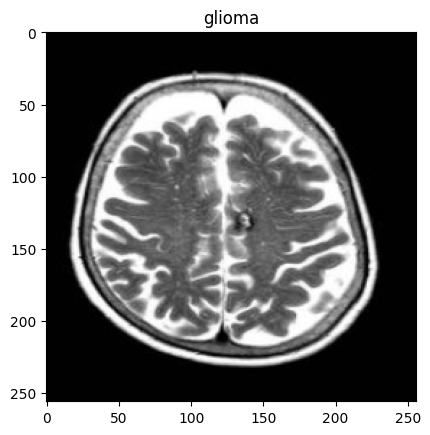

In [7]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes

data_transf = transforms.Compose([transforms.Resize((256, 256)),
                                  transforms.ToTensor()])

TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=32, shuffle=True)

ValidationDataset = ImageFolder(root='./Validation/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
ValidationLoader = DataLoader(ValidationDataset, batch_size= 32, shuffle=True)

for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [8]:
device= device = torch.device("cuda")

In [22]:
# @title VGG19

Classifier = models.vgg19(weights='DEFAULT')

for param in Classifier.features.parameters():
    param.requires_grad = False

num_features = Classifier.classifier[6].in_features


#Classifier.classifier[6] = nn.Linear(num_features, 2048).to(device)
#Classifier.classifier.add_module('relu1', nn.ReLU(inplace=True).to(device))
#Classifier.classifier.add_module('fc1', nn.Linear(2048, 4).to(device))
#Classifier.classifier.add_module('softmax', nn.Softmax(dim=1))
Classifier.classifier[6] = nn.Linear(num_features, 4).to(device) #Seemed very slow with grad=true




Classifier = Classifier.to(device)
summary(Classifier, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [21]:
#@title ResNet

resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = True    #Faster with grad=true(around 96% Validation Accuracy)

num_classes = 4
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)

summary(resnet, (3,256,256))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

Epoch 1, Batch 10, Loss: 0.539
Epoch 1, Batch 20, Loss: 0.355
Epoch 1, Batch 30, Loss: 0.255
Epoch 1, Batch 40, Loss: 0.169
Epoch 1, Batch 50, Loss: 0.233
Epoch 1, Batch 60, Loss: 0.164
Epoch 1, Batch 70, Loss: 0.148
Epoch 1, Batch 80, Loss: 0.159
Epoch 1, Batch 90, Loss: 0.129
Epoch 1, Batch 100, Loss: 0.181
Epoch 1, Batch 110, Loss: 0.223
Epoch 1, Batch 120, Loss: 0.156
Epoch 1, Batch 130, Loss: 0.215
Epoch 1, Batch 140, Loss: 0.195
Epoch 1 Loss: 0.703
Epoch 1 Validation Accuracy: 86.91%
Epoch 1 Validation Loss: 0.359
Epoch 2, Batch 10, Loss: 0.131
Epoch 2, Batch 20, Loss: 0.112
Epoch 2, Batch 30, Loss: 0.190
Epoch 2, Batch 40, Loss: 0.166
Epoch 2, Batch 50, Loss: 0.175
Epoch 2, Batch 60, Loss: 0.226
Epoch 2, Batch 70, Loss: 0.129
Epoch 2, Batch 80, Loss: 0.144
Epoch 2, Batch 90, Loss: 0.164
Epoch 2, Batch 100, Loss: 0.140
Epoch 2, Batch 110, Loss: 0.088
Epoch 2, Batch 120, Loss: 0.123
Epoch 2, Batch 130, Loss: 0.144
Epoch 2, Batch 140, Loss: 0.118
Epoch 2 Loss: 0.465
Epoch 2 Validat

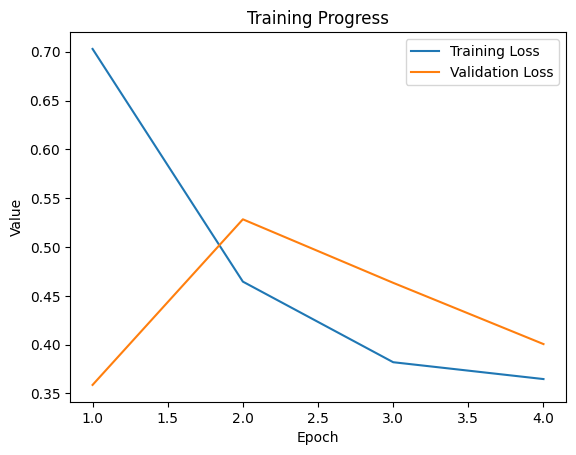

In [23]:
# @title Train with VGG

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Classifier.parameters(), lr=0.001)

num_epochs = 200

epoch_loss = []
val_loss = []
val_accuracy = []

best_loss = np.inf
best_weights = None
patience = 3
no_improvement = 0

for epoch in range(num_epochs):
    train_running_loss = 0.0
    mini_batch_loss = 0.0
    for batch_number, (images, labels) in enumerate(TrainingLoader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = Classifier(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        mini_batch_loss += loss.item()

        if (batch_number + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Batch {batch_number + 1}, Loss: {mini_batch_loss / 32:.3f}')
            mini_batch_loss = 0.0

    epoch_loss.append(train_running_loss / len(TrainingLoader))

    # Validation
    correct = 0
    total = 0
    val_running_loss = 0.0

    for images, labels in ValidationLoader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = Classifier(images)
        loss = loss_function(outputs, labels)

        val_running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)
    val_loss.append(val_running_loss / len(ValidationLoader))

    # Early Stopping
    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        best_weights = Classifier.state_dict()
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    print(f'Epoch {epoch + 1} Loss: {train_running_loss / len(TrainingLoader):.3f}')
    print(f'Epoch {epoch + 1} Validation Accuracy: {val_accuracy[-1]:.2f}%')
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss[-1]:.3f}')

print('Finished Training')

# Best Weights
Classifier.load_state_dict(best_weights)

print('Finished Training')

# Plots
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss, label='Training Loss')
plt.plot(range(1, len(epoch_loss) + 1), val_loss, label='Validation Loss')


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.show()

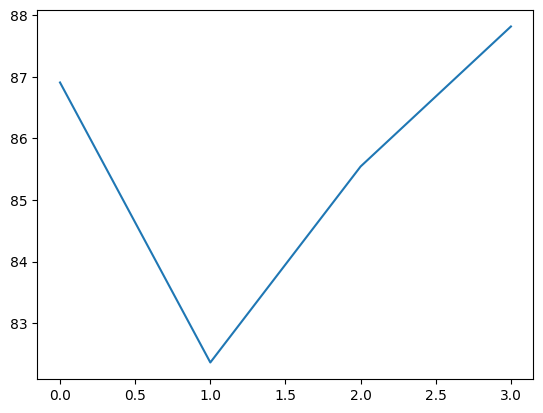

In [24]:
plt.plot(val_accuracy)

In [ ]:
# @title Test with VGG


correct = 0
total = 0
test_running_loss = 0.0

for images, labels in TestLoader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = Classifier(images)
    loss = loss_function(outputs, labels)

    test_running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
average_test_loss = test_running_loss / len(TestLoader)

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Average Test Loss: {average_test_loss:.3f}')

Epoch 1, Batch 10, Loss: 0.250
Epoch 1, Batch 20, Loss: 0.156
Epoch 1, Batch 30, Loss: 0.142
Epoch 1, Batch 40, Loss: 0.158
Epoch 1, Batch 50, Loss: 0.109
Epoch 1, Batch 60, Loss: 0.129
Epoch 1, Batch 70, Loss: 0.116
Epoch 1, Batch 80, Loss: 0.098
Epoch 1, Batch 90, Loss: 0.119
Epoch 1, Batch 100, Loss: 0.101
Epoch 1, Batch 110, Loss: 0.117
Epoch 1, Batch 120, Loss: 0.087
Epoch 1, Batch 130, Loss: 0.073
Epoch 1, Batch 140, Loss: 0.072
Epoch 1 Loss: 0.391
Epoch 1 Validation Accuracy: 91.09%
Epoch 1 Validation Loss: 0.269
Epoch 2, Batch 10, Loss: 0.090
Epoch 2, Batch 20, Loss: 0.056
Epoch 2, Batch 30, Loss: 0.057
Epoch 2, Batch 40, Loss: 0.056
Epoch 2, Batch 50, Loss: 0.043
Epoch 2, Batch 60, Loss: 0.065
Epoch 2, Batch 70, Loss: 0.022
Epoch 2, Batch 80, Loss: 0.048
Epoch 2, Batch 90, Loss: 0.037
Epoch 2, Batch 100, Loss: 0.075
Epoch 2, Batch 110, Loss: 0.074
Epoch 2, Batch 120, Loss: 0.062
Epoch 2, Batch 130, Loss: 0.067
Epoch 2, Batch 140, Loss: 0.057
Epoch 2 Loss: 0.190
Epoch 2 Validat

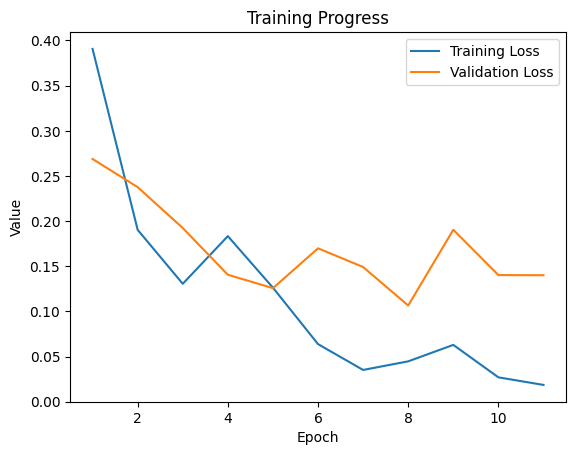

In [25]:
# @title Train with resnet

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

num_epochs = 200

epoch_loss = []
val_loss = []
val_accuracy = []

best_loss = np.inf
best_weights = None
patience = 3
no_improvement = 0

for epoch in range(num_epochs):
    train_running_loss = 0.0
    mini_batch_loss = 0.0
    for batch_number, (images, labels) in enumerate(TrainingLoader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        mini_batch_loss += loss.item()

        if (batch_number + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Batch {batch_number + 1}, Loss: {mini_batch_loss / 32:.3f}')
            mini_batch_loss = 0.0

    epoch_loss.append(train_running_loss / len(TrainingLoader))

    # Validation
    correct = 0
    total = 0
    val_running_loss = 0.0

    for images, labels in ValidationLoader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet(images)
        loss = loss_function(outputs, labels)

        val_running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)
    val_loss.append(val_running_loss / len(ValidationLoader))

    # Early Stopping
    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        best_weights = resnet.state_dict()
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    print(f'Epoch {epoch + 1} Loss: {train_running_loss / len(TrainingLoader):.3f}')
    print(f'Epoch {epoch + 1} Validation Accuracy: {val_accuracy[-1]:.2f}%')
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss[-1]:.3f}')

print('Finished Training')

# Best Weights
resnet.load_state_dict(best_weights)

print('Finished Training')

# Plots
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss, label='Training Loss')
plt.plot(range(1, len(epoch_loss) + 1), val_loss, label='Validation Loss')


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.show()

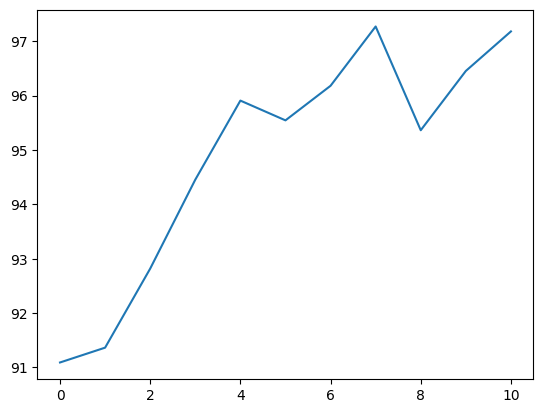

In [26]:
plt.plot(val_accuracy)

In [ ]:
# @title Test with resnet


correct = 0
total = 0
test_running_loss = 0.0

for images, labels in TestLoader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = Classifier(images)
    loss = loss_function(outputs, labels)

    test_running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
average_test_loss = test_running_loss / len(TestLoader)

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Average Test Loss: {average_test_loss:.3f}')